In [15]:
#ライブラリのインポート
import glob
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import optuna

#lgb用
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from lightgbm import LGBMRegressor

from sklearn.model_selection import KFold
import optuna.integration.lightgbm as o_lgb

#警告を非表示
import warnings
warnings.simplefilter('ignore')

import time
#seaborn 可視化用
%matplotlib inline

In [16]:
#Pathの設定
DATA_PATH = '../data/ubiquant-parquet/'

#省略表示のキャンセル
pd.set_option('display.max_columns', 10000000)
pd.set_option('display.max_rows', 10000000)

In [17]:
print(DATA_PATH + 'train.parquet')

../data/ubiquant-parquet/train.parquet


In [18]:
%%time
train = pd.read_parquet(DATA_PATH + 'train.parquet') 

Wall time: 6min 21s


In [5]:
train.shape

(3141410, 304)

In [19]:
train.raws()

AttributeError: 'DataFrame' object has no attribute 'raws'

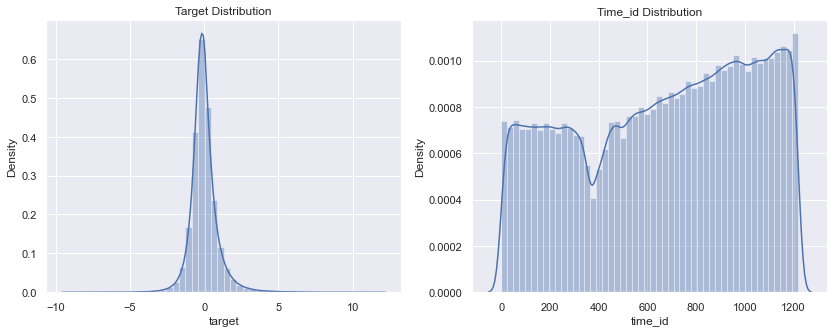

In [6]:
#Target Distribution & Time_id Distribution
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.distplot(train['target'], ax=ax[0]).set_title('Target Distribution')
sns.distplot(train['time_id'], ax=ax[1]).set_title('Time_id Distribution')
fig.show()
plt.show()

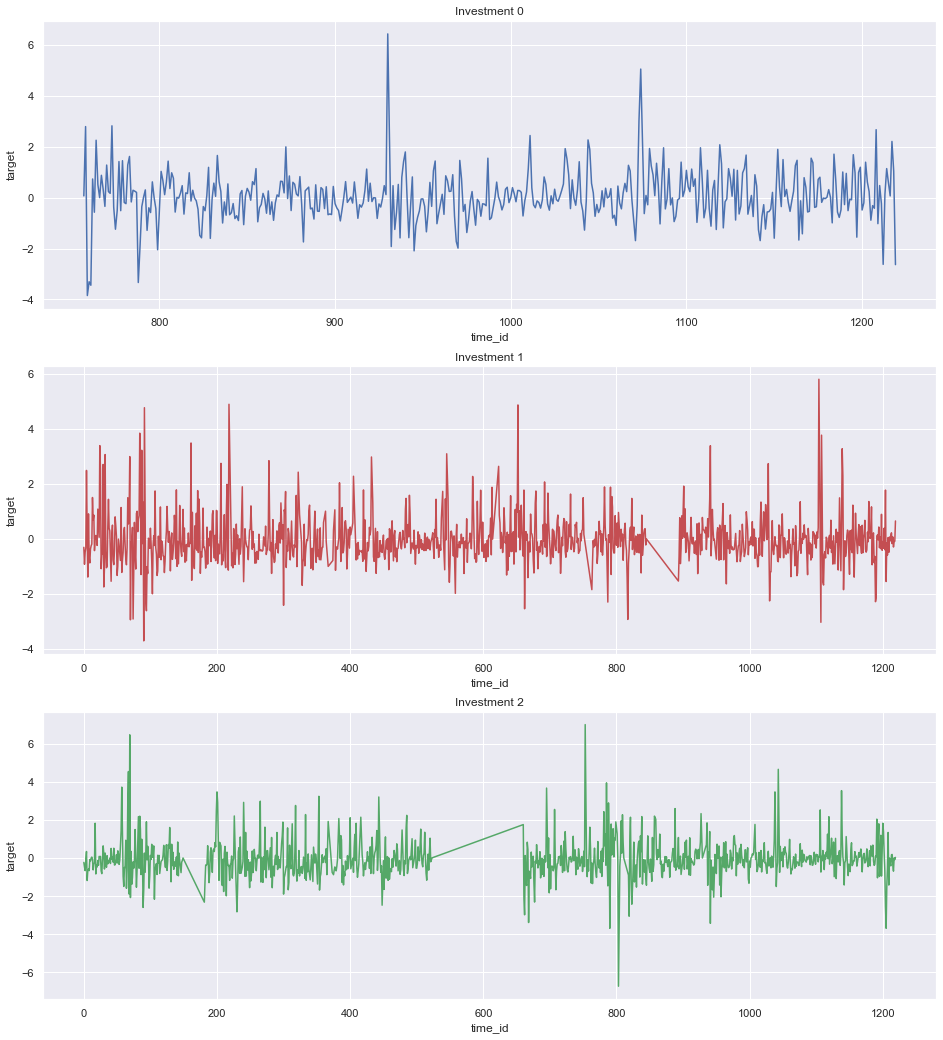

In [7]:
#investment_id別targetの分布
sns.set_theme()
fig, ax =plt.subplots(3,1, figsize=(16, 18))
sns.lineplot(data=train[train['investment_id']==0],
             y=train[train['investment_id']==0]['target'],
             x=train[train['investment_id']==0]['time_id'],
             ax=ax[0]
            ).set_title('Investment 0')
sns.lineplot(data=train[train['investment_id']==1],
             y=train[train['investment_id']==1]['target'],
             x=train[train['investment_id']==1]['time_id'],
             ax=ax[1],
             color='r'
            ).set_title('Investment 1')
sns.lineplot(data=train[train['investment_id']==2],
             y=train[train['investment_id']==2]['target'],
             x=train[train['investment_id']==2]['time_id'],
             ax=ax[2],
             color='g'
            ).set_title('Investment 2')
fig.show()

<AxesSubplot:>

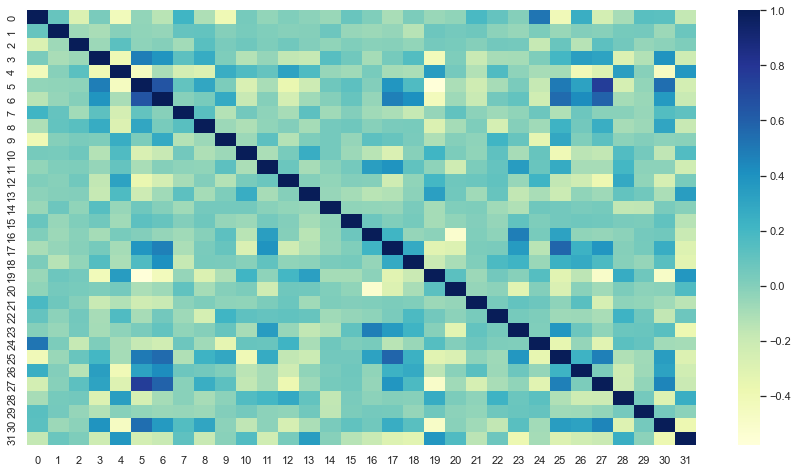

In [8]:
#investment_id=0について、time_idとtargetと、特徴量1~30までの相関（図中,0=time_id,1=target）
investment_0 = train[train['investment_id']==0]
df = investment_0.drop(['row_id', 'investment_id'], axis=1)
del investment_0
df_30 = df.iloc[: , :32]
del df
corrMatrix = df_30.corr()
plt.figure(figsize = (15,8))
sns.heatmap(corrMatrix.to_numpy(), cmap="YlGnBu")

In [14]:
train.rows

NameError: name 'train' is not defined

In [10]:
%%time
#lightGBM_データ準備
train.drop(['row_id', 'time_id'], axis=1, inplace=True)
X = train.drop(['target'], axis=1)
y = train["target"]
del train
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
del X
del y


Wall time: 15min 11s


In [13]:
%%time
#lightGBM実行
model = LGBMRegressor(
        objective="regression",
        metric="rmse",
        boosting_type="gbdt",
        n_estimators=1400,
        num_leaves=100,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8
)

model.fit(X_train, y_train,
          eval_set=[(X_valid, y_valid)],
          verbose=2,
          eval_metric='rmse',
          early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds
[2]	valid_0's rmse: 0.902942
[4]	valid_0's rmse: 0.902096
[6]	valid_0's rmse: 0.901372
[8]	valid_0's rmse: 0.900736
[10]	valid_0's rmse: 0.900179
[12]	valid_0's rmse: 0.899707
[14]	valid_0's rmse: 0.899365
[16]	valid_0's rmse: 0.89905
[18]	valid_0's rmse: 0.898773
[20]	valid_0's rmse: 0.898515
[22]	valid_0's rmse: 0.898258
[24]	valid_0's rmse: 0.897979
[26]	valid_0's rmse: 0.897793
[28]	valid_0's rmse: 0.897615
[30]	valid_0's rmse: 0.897501
[32]	valid_0's rmse: 0.897392
[34]	valid_0's rmse: 0.897229
[36]	valid_0's rmse: 0.897105
[38]	valid_0's rmse: 0.897032
[40]	valid_0's rmse: 0.896955
[42]	valid_0's rmse: 0.896876
[44]	valid_0's rmse: 0.896793
[46]	valid_0's rmse: 0.896692
[48]	valid_0's rmse: 0.896612
[50]	valid_0's rmse: 0.896574
[52]	valid_0's rmse: 0.896535
[54]	valid_0's rmse: 0.896447
[56]	valid_0's rmse: 0.896393
[58]	valid_0's rmse: 0.896351
[60]	valid_0's rmse: 0.896297
[62]	valid_0's rmse: 0.896222
[64]	valid_0'

LGBMRegressor(learning_rate=0.05, max_depth=10, metric='rmse',
              n_estimators=1400, num_leaves=100, objective='regression',
              subsample=0.8)

In [1]:
feature_cols = [f'f_{i}' for i in range(300)]

In [2]:
feature_cols

['f_0',
 'f_1',
 'f_2',
 'f_3',
 'f_4',
 'f_5',
 'f_6',
 'f_7',
 'f_8',
 'f_9',
 'f_10',
 'f_11',
 'f_12',
 'f_13',
 'f_14',
 'f_15',
 'f_16',
 'f_17',
 'f_18',
 'f_19',
 'f_20',
 'f_21',
 'f_22',
 'f_23',
 'f_24',
 'f_25',
 'f_26',
 'f_27',
 'f_28',
 'f_29',
 'f_30',
 'f_31',
 'f_32',
 'f_33',
 'f_34',
 'f_35',
 'f_36',
 'f_37',
 'f_38',
 'f_39',
 'f_40',
 'f_41',
 'f_42',
 'f_43',
 'f_44',
 'f_45',
 'f_46',
 'f_47',
 'f_48',
 'f_49',
 'f_50',
 'f_51',
 'f_52',
 'f_53',
 'f_54',
 'f_55',
 'f_56',
 'f_57',
 'f_58',
 'f_59',
 'f_60',
 'f_61',
 'f_62',
 'f_63',
 'f_64',
 'f_65',
 'f_66',
 'f_67',
 'f_68',
 'f_69',
 'f_70',
 'f_71',
 'f_72',
 'f_73',
 'f_74',
 'f_75',
 'f_76',
 'f_77',
 'f_78',
 'f_79',
 'f_80',
 'f_81',
 'f_82',
 'f_83',
 'f_84',
 'f_85',
 'f_86',
 'f_87',
 'f_88',
 'f_89',
 'f_90',
 'f_91',
 'f_92',
 'f_93',
 'f_94',
 'f_95',
 'f_96',
 'f_97',
 'f_98',
 'f_99',
 'f_100',
 'f_101',
 'f_102',
 'f_103',
 'f_104',
 'f_105',
 'f_106',
 'f_107',
 'f_108',
 'f_109',
 'f_110',
